# Validate the nonspecific bead interaction contribution to the field energy

### Navigate to root directory

In [1]:
# Built-in modules
import os
import sys

# Insert package root to system path
cwd = os.getcwd()
parent_dir = cwd + "/../.."
sys.path.insert(1, parent_dir)

print("Directory containing the notebook:")
print(cwd)

Directory containing the notebook:
/home/users/jwakim/CodeDev/chromo_check_density_calculation/doc/tools


In [2]:
# Change working directory to package root
os.chdir(parent_dir)
print("Root Directory of Package: ")
print(os.getcwd())

Root Directory of Package: 
/home/users/jwakim/CodeDev/chromo_check_density_calculation


### Import modules

In [3]:
# External modules
import numpy as np
import matplotlib.pyplot as plt

# Package modules
from chromo.polymers import SSWLC
import chromo.binders
from chromo.fields import UniformDensityField

### Specify reader proteins

In [4]:
hp1 = chromo.binders.get_by_name("HP1")
binders = chromo.binders.make_binder_collection([hp1])

### Specify confinement

In [5]:
bead_vol = 1
bead_rad = np.cbrt(bead_vol / (4/3 * np.pi))

confine_type = "Cubical"
voxel_count = 1
voxel_sizes = np.arange(10, 101, 0.2)

n_beads = int(np.ceil(0.5 * voxel_sizes[0]**3 / bead_vol + 1))

chemical_mods = np.atleast_2d(np.ones(n_beads, dtype=int)).T
states = chemical_mods.copy()
reader = chromo.binders.get_by_name("null_reader")
binders = chromo.binders.make_binder_collection([reader])

chi = 1

### Initialize polymer and field

In [6]:
%%capture

udfs = []
polymers = []
out_dirs = []
delta = 50

for i, voxel_size in enumerate(voxel_sizes):

    # Instantiate Polymer
    r = np.ones((n_beads, 3), dtype=float) * voxel_size/2
    t3 = np.zeros((n_beads, 3), dtype=float)
    t2 = np.zeros((n_beads, 3), dtype=float)
    poly = SSWLC(
        name = "polymer",
        r = r,
        bead_length = 1,
        lp = 0.1,
        bead_rad = bead_rad,
        t3 = t3,
        t2 = t2,
        states = states,
        binder_names=np.array(['null_reader']),
        chemical_mods=chemical_mods,
        chemical_mod_names=np.array(['null_mods'])
    )
    polymers.append(poly)

    # Instantiate Field
    n_bins_x = 1
    n_bins_y = 1
    n_bins_z = 1
    x_width = voxel_size
    y_width = voxel_size
    z_width = voxel_size
    udf = UniformDensityField(
        polymers = [poly],
        binders = binders,
        x_width = x_width,
        nx = n_bins_x,
        y_width = y_width,
        ny = n_bins_y,
        z_width = z_width,
        nz = n_bins_z,
        confine_type = confine_type,
        confine_length = voxel_size,
        chi = chi
    )
    udfs.append(udf)

### Calculate nonspecific interaction energy

In [7]:
voxel_vols = []
nonspecific_Es = []
nonspecific_Es_theory = []

for i, voxel_size in enumerate(voxel_sizes):
    voxel_vols.append(voxel_size**3)
    nonspecific_Es.append(udfs[i].nonspecific_interact_E(polymers[i]))

    if n_beads > 0.5 * voxel_vols[i] / bead_vol:
        nonspecific_Es_theory.append(1E99)
    else:
        nonspecific_Es_theory.append(chi * voxel_vols[i] * (n_beads * bead_vol / voxel_vols[i])**2)

voxel_vols = np.array(voxel_vols)
nonspecific_Es = np.array(nonspecific_Es)
nonspecific_Es_theory = np.array(nonspecific_Es_theory)

print("Voxel Volume (nm^3):")
print(voxel_vols)
print("Nonspecific Interaction Energy from Simulation (kT):")
print(nonspecific_Es)
print("Nonspecific Interaction Energy from Theory (kT):")
print(nonspecific_Es_theory)

Voxel Volume (nm^3):
[1.00000000e+03 1.06120800e+03 1.12486400e+03 1.19101600e+03
 1.25971200e+03 1.33100000e+03 1.40492800e+03 1.48154400e+03
 1.56089600e+03 1.64303200e+03 1.72800000e+03 1.81584800e+03
 1.90662400e+03 2.00037600e+03 2.09715200e+03 2.19700000e+03
 2.29996800e+03 2.40610400e+03 2.51545600e+03 2.62807200e+03
 2.74400000e+03 2.86328800e+03 2.98598400e+03 3.11213600e+03
 3.24179200e+03 3.37500000e+03 3.51180800e+03 3.65226400e+03
 3.79641600e+03 3.94431200e+03 4.09600000e+03 4.25152800e+03
 4.41094400e+03 4.57429600e+03 4.74163200e+03 4.91300000e+03
 5.08844800e+03 5.26802400e+03 5.45177600e+03 5.63975200e+03
 5.83200000e+03 6.02856800e+03 6.22950400e+03 6.43485600e+03
 6.64467200e+03 6.85900000e+03 7.07788800e+03 7.30138400e+03
 7.52953600e+03 7.76239200e+03 8.00000000e+03 8.24240800e+03
 8.48966400e+03 8.74181600e+03 8.99891200e+03 9.26100000e+03
 9.52812800e+03 9.80034400e+03 1.00776960e+04 1.03602320e+04
 1.06480000e+04 1.09410480e+04 1.12394240e+04 1.15431760e+04
 1.

### Plot nonspecific interaction energies

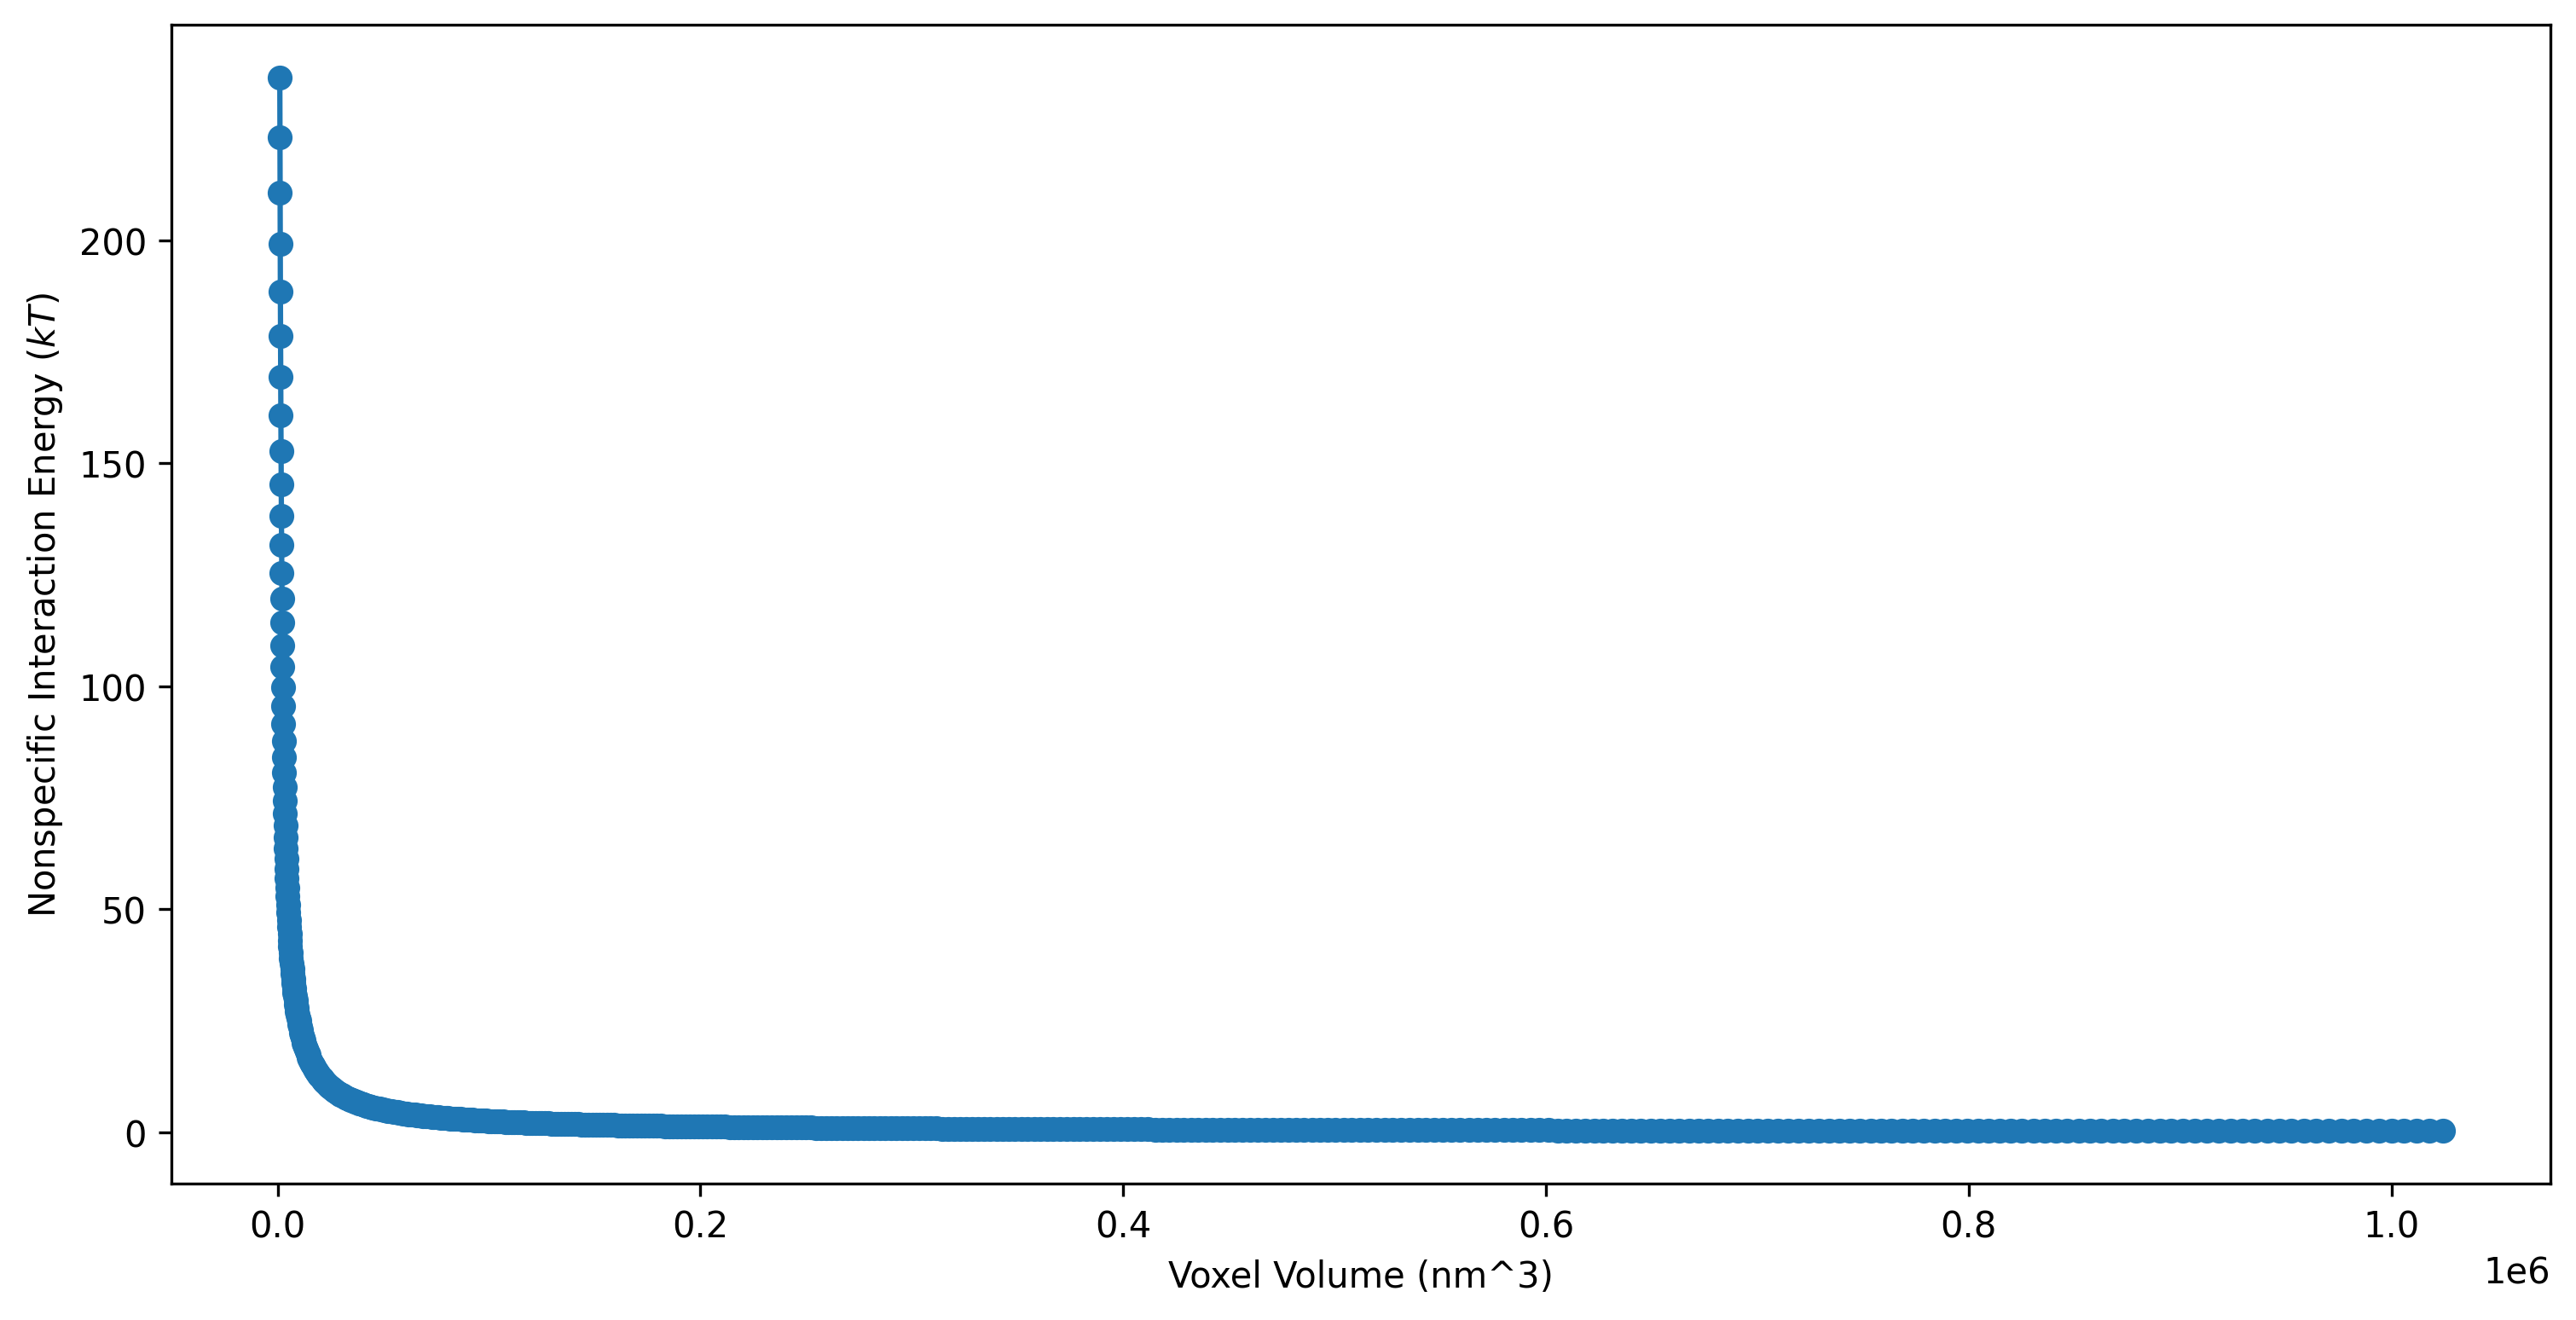

In [8]:
plt.figure(figsize=(12,6), dpi=300)
plt.scatter(voxel_vols[1:], nonspecific_Es[1:])
plt.plot(voxel_vols[1:], nonspecific_Es_theory[1:])
plt.xlabel(r"Voxel Volume (nm^3)")
plt.ylabel(r"Nonspecific Interaction Energy ($kT$)")
plt.show()